In [1]:
import os,librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties

In [11]:
seed=42
n_MFCC=13
column_names= ['MFCC_'+str(i) for i in range(1,n_MFCC+1)]

In [12]:
DATA_PATH="./Vowel_Data/Vowel/"

In [13]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

prop=FontProperties()
prop.set_file('/home/rakibul/STUDY/Software/Windows/Fonts/Kalpurush.ttf')

def plot_cnf_mat(cm,classes,title,normalize=True): #Normalization can be avoided by setting normalize=False
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    plt.figure(figsize=(10,9))
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontproperties=prop,fontsize=24)
    plt.yticks(tick_marks,classes,fontproperties=prop,fontsize=24)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black",fontsize=18)
    
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    plt.tight_layout()
    plt.savefig('./New_without_CNN/'+title+'.pdf',format='pdf', dpi=600)

In [16]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)

model_v=Sequential()
model_v.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

model_v.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['AUC']
)

model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0])
y_pred=model_v.predict_classes(X_test)

Reading Speech of label -'vowel7': 100%|██████████| 40/40 [00:00<00:00, 105.04it/s]


Epoch 1/50
1/1 [==============================] - 0s 8ms/step - loss: 2.2058 - auc: 0.4095
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 2.0868 - auc: 0.4789
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 1.9768 - auc: 0.5593
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 1.8766 - auc: 0.6367
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 1.7862 - auc: 0.7022
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 1.7052 - auc: 0.7563
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6327 - auc: 0.7978
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 1.5676 - auc: 0.8272
Epoch 9/50
1/1 [==============================] - 0s 1ms/step - loss: 1.5089 - auc: 0.8477
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 1.4555 - auc: 0.8624
Epoch 11/50
1/1 [==============================] - 0s 1ms/step - loss: 1.4068 - auc: 0.87

Normalized confusion matrix
[[0.84 0.1  0.   0.01 0.   0.   0.05]
 [0.11 0.86 0.   0.02 0.   0.   0.01]
 [0.   0.01 0.76 0.01 0.21 0.   0.01]
 [0.   0.02 0.02 0.89 0.   0.   0.07]
 [0.   0.   0.19 0.01 0.67 0.12 0.02]
 [0.   0.   0.06 0.   0.09 0.81 0.04]
 [0.09 0.02 0.02 0.15 0.13 0.19 0.4 ]]


<Figure size 432x288 with 0 Axes>

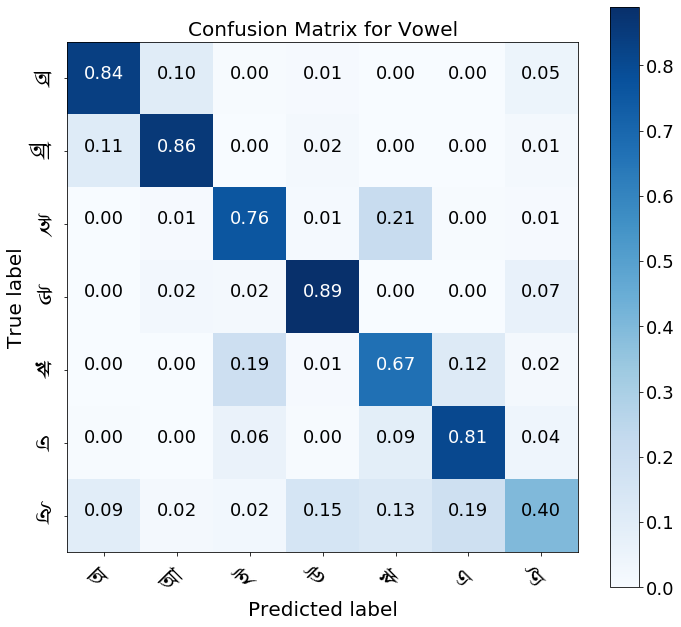

In [17]:
class_names=['অ ','আ ','ই ','উ ','ঋ ','এ ','ঐ ']
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Vowel')
plt.show()

In [18]:
DATA_PATH="./Word_Data/Word/"

In [20]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

prop=FontProperties()
prop.set_file('/home/rakibul/STUDY/Software/Windows/Fonts/Kalpurush.ttf')

def plot_cnf_mat(cm,classes,title,normalize=True): #Normalization can be avoided by setting normalize=False
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    plt.figure(figsize=(10,9))
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontproperties=prop,fontsize=24)
    plt.yticks(tick_marks,classes,fontproperties=prop,fontsize=24)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black",fontsize=18)
    
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    plt.tight_layout()
    plt.savefig('./New_without_CNN/'+title+'.pdf',format='pdf', dpi=600)

In [21]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)

model_w=Sequential()
model_w.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['AUC']
)

model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0])
y_pred=model_w.predict_classes(X_test)

Reading Speech of label -'Word7': 100%|██████████| 40/40 [00:00<00:00, 99.27it/s]


Epoch 1/50
1/1 [==============================] - 0s 2ms/step - loss: 1.9145 - auc: 0.5931
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 1.8533 - auc: 0.6309
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 1.7991 - auc: 0.6638
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 1.7512 - auc: 0.6922
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 1.7090 - auc: 0.7156
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 1.6718 - auc: 0.7347
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 1.6389 - auc: 0.7499
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 1.6098 - auc: 0.7624
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 1.5841 - auc: 0.7724
Epoch 10/50
1/1 [==============================] - 0s 1ms/step - loss: 1.5613 - auc: 0.7806
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 1.5412 - auc: 0.78

Normalized confusion matrix
[[0.58 0.2  0.04 0.12 0.01 0.02 0.02]
 [0.2  0.38 0.09 0.26 0.   0.   0.07]
 [0.08 0.16 0.41 0.07 0.07 0.11 0.1 ]
 [0.17 0.16 0.02 0.57 0.02 0.01 0.05]
 [0.   0.   0.03 0.   0.9  0.04 0.02]
 [0.03 0.05 0.15 0.25 0.26 0.22 0.05]
 [0.16 0.16 0.1  0.16 0.05 0.08 0.29]]


<Figure size 432x288 with 0 Axes>

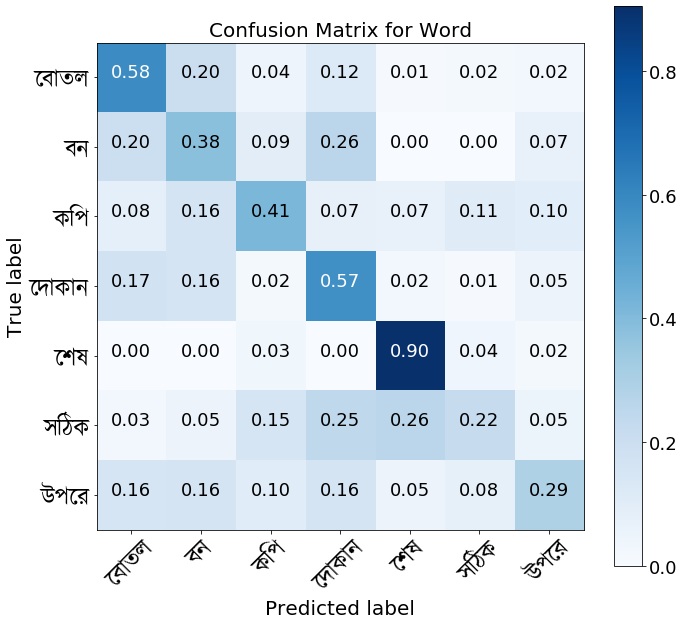

In [22]:
class_names=['েবাতল','বন','কিপ','েদাকান','েশষ','সিঠক','উপের']
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Word')
plt.show()